In [17]:
#!pip install spei

In [34]:
import numpy as np
import pandas as pd

# Import matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
import pandas as pd
import numpy as np
import spei
import matplotlib as plt

In [3]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 48AB-B2FD

 Directory of C:\Users\mihir\Desktop\SAS Hackathon\Working Directory

04/02/2023  09:53 AM    <DIR>          .
04/02/2023  09:53 AM    <DIR>          ..
03/30/2023  06:53 PM    <DIR>          .ipynb_checkpoints
04/02/2023  04:42 PM    <DIR>          Data OKC
04/02/2023  09:53 AM             6,021 Untitled.ipynb
               1 File(s)          6,021 bytes
               4 Dir(s)  17,838,649,344 bytes free


In [25]:
df = pd.read_csv('Data OKC\my_data.csv')

In [26]:
df.head()

,YEAR,MONTH,DAY,STID,RAIN
0,2007,4,20,OKCE,0.00
1,2007,4,21,OKCE,0.00
2,2007,4,22,OKCE,0.00
3,2007,4,23,OKCE,0.00
4,2007,4,24,OKCE,0.21


In [27]:
df.shape

(5726, 5)

In [28]:
df['datetime'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [29]:
df.head()

,YEAR,MONTH,DAY,STID,RAIN,datetime
0,2007,4,20,OKCE,0.00,2007-04-20
1,2007,4,21,OKCE,0.00,2007-04-21
2,2007,4,22,OKCE,0.00,2007-04-22
3,2007,4,23,OKCE,0.00,2007-04-23
4,2007,4,24,OKCE,0.21,2007-04-24


In [30]:
df.set_index("datetime", inplace=True)

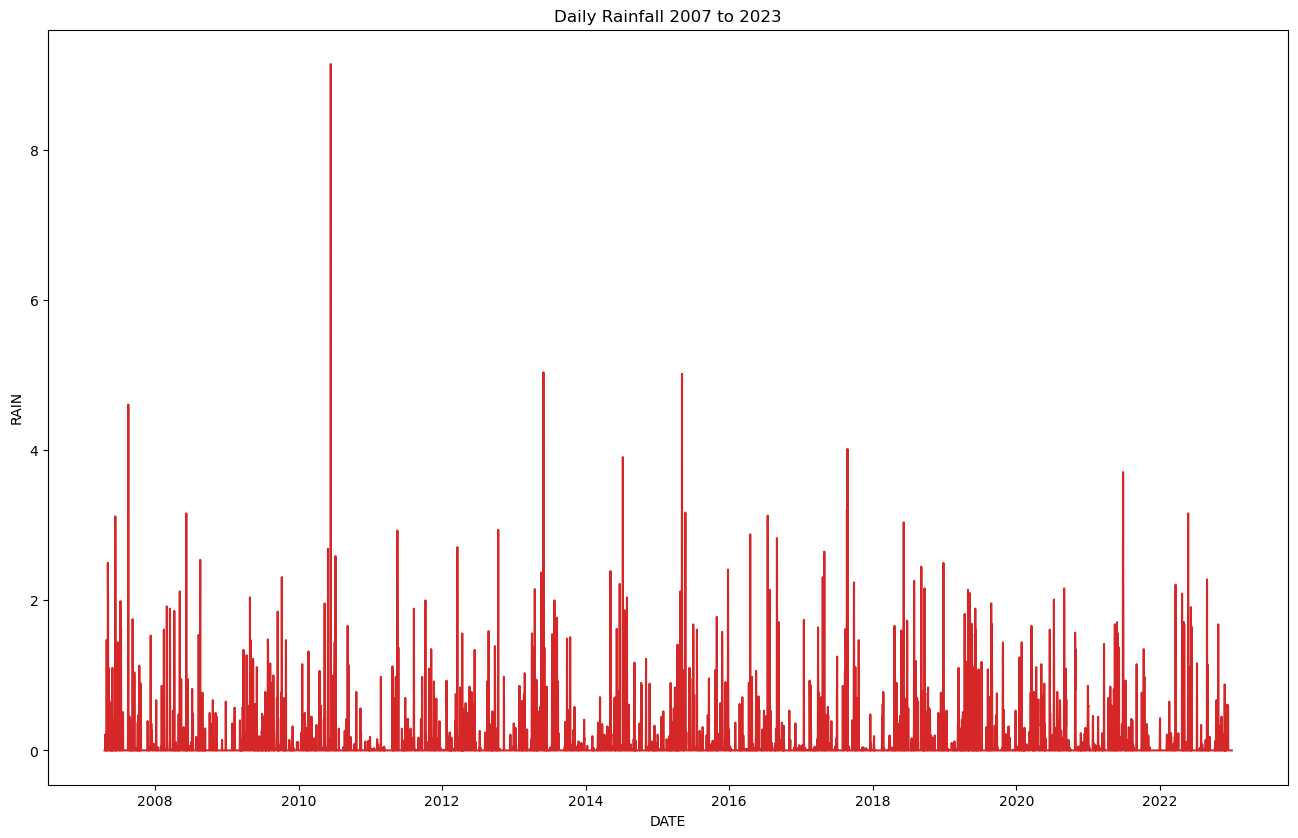

In [35]:
# Plot the daily temperature change 
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df.index, df.RAIN, color='tab:red')
plt.gca().set(title="Daily Rainfall 2007 to 2023", xlabel='DATE', ylabel="RAIN")
plt.show()

<AxesSubplot:xlabel='datetime'>

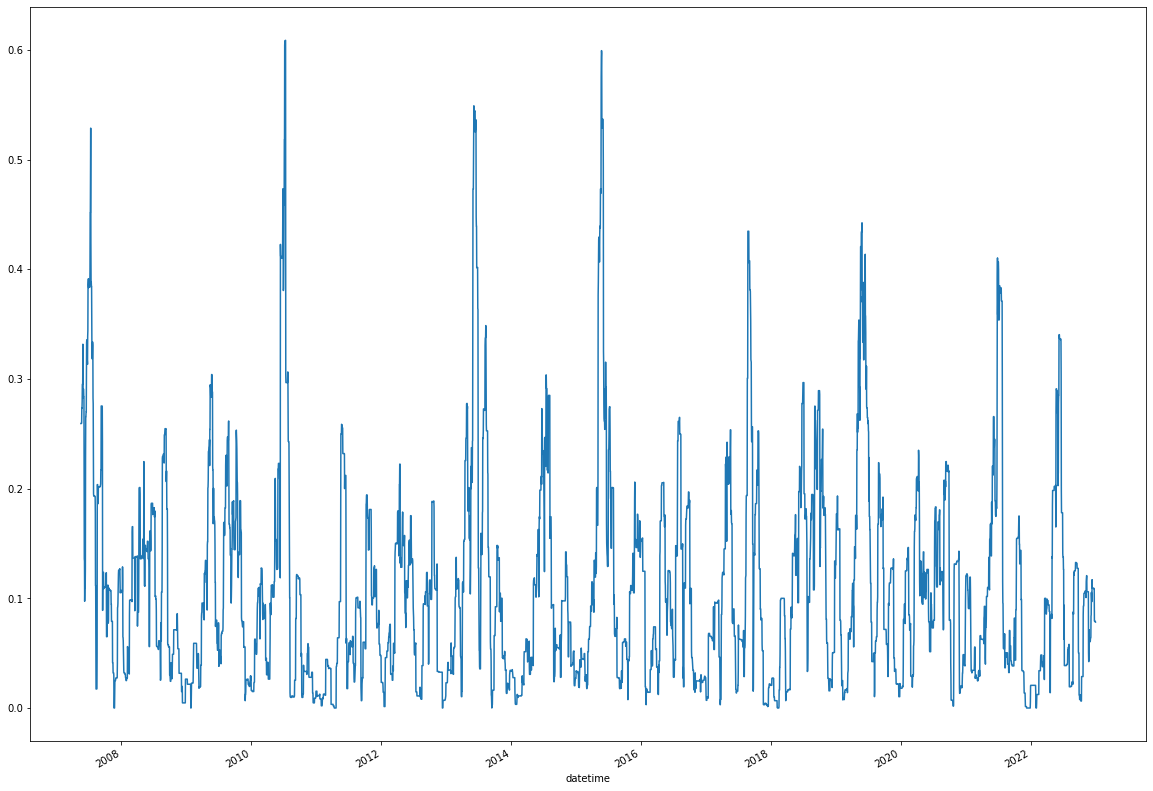

In [36]:
# Apply the Moving Average function by a subset of size 30 days.
#The moving average is mostly used with time series data to capture the short-term fluctuations while focusing on longer trends
df_mean = df.RAIN.rolling(window=30).mean()
df_mean.plot(figsize=(20,15))

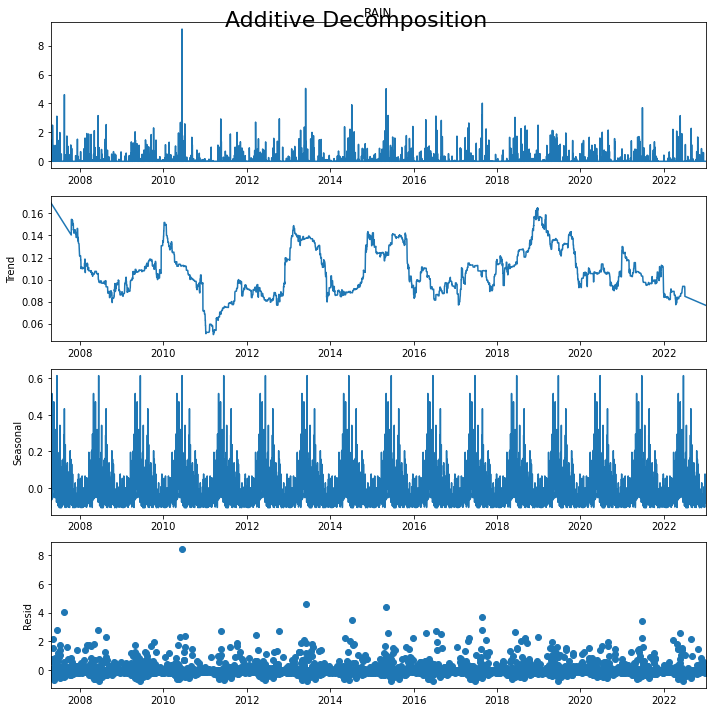

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df.RAIN, model='additive', extrapolate_trend='freq', period = 365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

## Baseline Model

In [42]:
# Shift the current rainfall to the next day. 
predicted_df = df["RAIN"].to_frame().shift(1).rename(columns = {"RAIN": "RAIN_pred" })
actual_df = df["RAIN"].to_frame().rename(columns = {"RAIN": "RAIN_actual" })

# Concatenate the actual and predicted RAINFALL
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,RAIN_actual,RAIN_pred
datetime,,
2007-04-21,0.00,0.00
2007-04-22,0.00,0.00
2007-04-23,0.00,0.00
2007-04-24,0.21,0.00
2007-04-25,0.01,0.21
2007-04-26,0.00,0.01
2007-04-27,0.21,0.00
2007-04-28,0.00,0.21
2007-04-29,0.00,0.00


In [44]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
rain_pred_err = MSE(one_step_df.RAIN_actual, one_step_df.RAIN_pred, squared=False)
print("The RMSE is",rain_pred_err)

The RMSE is 0.5080542556042166


##### Rainfall error is high that means we cant use previous data to predict the next day

### SARIMA : Since there is a seasonal pattern

In [45]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [47]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.RAIN_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

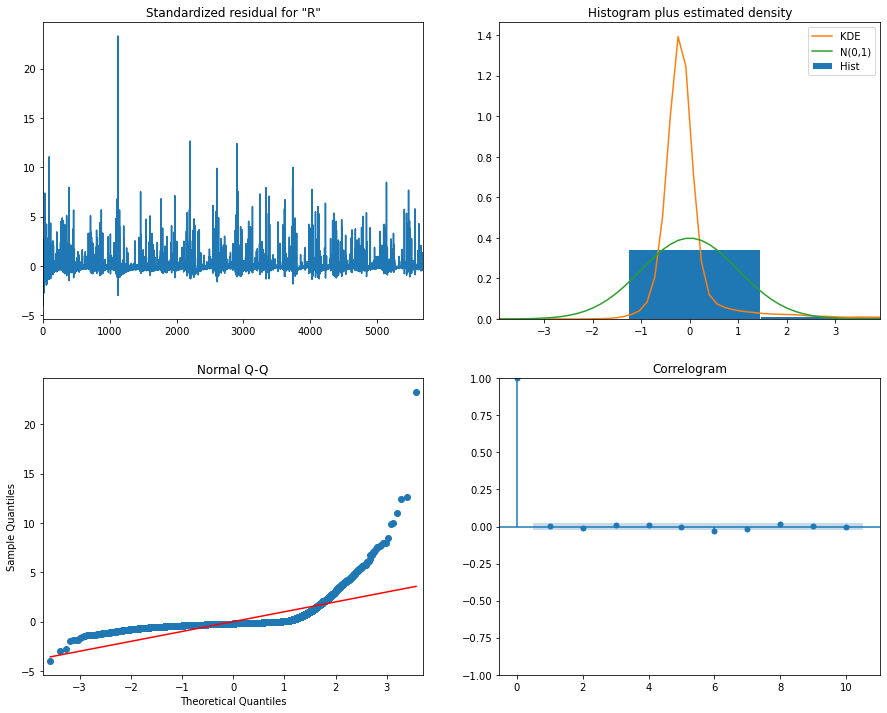

In [48]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()

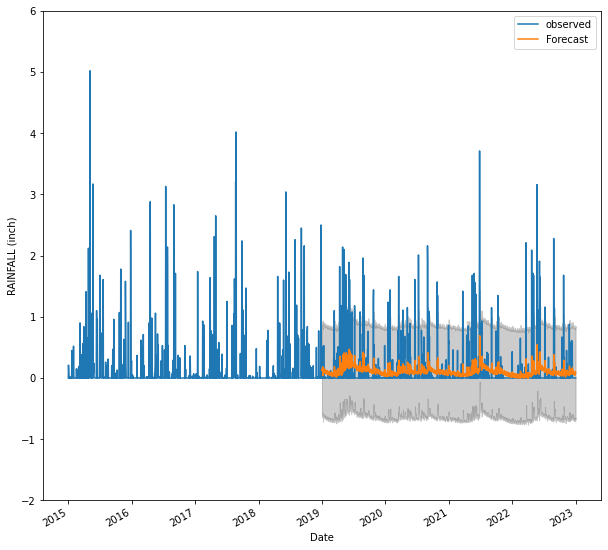

In [54]:
ax = one_step_df.RAIN_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('RAINFALL (inch)')
plt.ylim([-2,6])
plt.legend()
plt.show()

In [55]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.RAIN_actual['2019-01-01':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(1462,)
(1462,)
The Mean Squared Error of our forecasts is 0.12
